In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [61]:
def get_img_mat(img_path):
    img = Image.open(img_path)
    img_array = np.array(img)
    return img_array

def get_gray_img_mat(img_path):
    img = Image.open(img_path).convert('L')
    img_array = np.array(img)
    return img_array

def compute_fft_2d(data):
    """
    Compute the 2D FFT of a NumPy array.

    Parameters:
    - data: 2D NumPy array

    Returns:
    - fft_result: 2D FFT of the input array
    """
    fft_result = np.fft.fft2(data)
    # shift the zero frequency components to the center
    return np.fft.fftshift(fft_result)    


def get_fft_magnitude_spectrum(image_fft):
    # Compute the magnitude spectrum
    return np.abs(image_fft)
    
def plot_fft(fft_result):
    magnitude_spectrum = get_fft_magnitude_spectrum(fft_result)
    plot_fft_magnitude_spectrum(magnitude_spectrum)

def plot_fft_magnitude_spectrum(shifted_spectrum):
    # Apply log scale for better visualization (avoid very small values dominating)
    log_spectrum = np.log(1 + shifted_spectrum)

    # Display the result as an image
    plt.imshow(log_spectrum, cmap='gray')
    plt.title('Log Magnitude Spectrum')
    plt.colorbar(label='Log Magnitude')
    plt.show()
    
def get_image_from_fft(fft):
    return np.abs(np.fft.ifft2(fft))

In [54]:

img = get_gray_img_mat('./assets/grayscale-cat.jpeg')


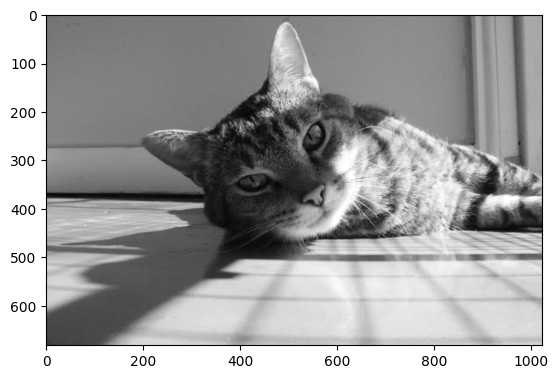

In [55]:
plt.imshow(img, cmap="gray")

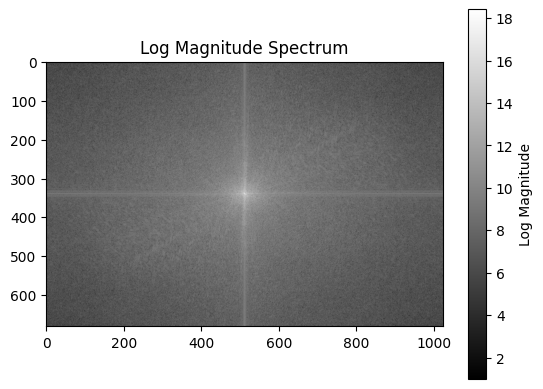

In [56]:
FFT = compute_fft_2d(img)
plot_fft(FFT)

In [71]:
#this method is used to create a pyramid slice of the image using fourier transform
#it gets the image, perform the fourier transform, then slice the image and perform the inverse fourier transform
#to get the pyramid slice
# the slice size is half the size of the image
def get_pyramid_fft_slice(img):
    #get the fourier transform of the image
    FFT = compute_fft_2d(img)
    #get the center of the image
    center = (img.shape[0]//2, img.shape[1]//2)
    #get the slice size
    slice_size = (img.shape[0]//4, img.shape[1]//4)
    #get the slice of the magnitude spectrum
    slice = FFT[center[0]-slice_size[0]:center[0]+slice_size[0], center[1]-slice_size[1]:center[1]+slice_size[1]]
    return slice


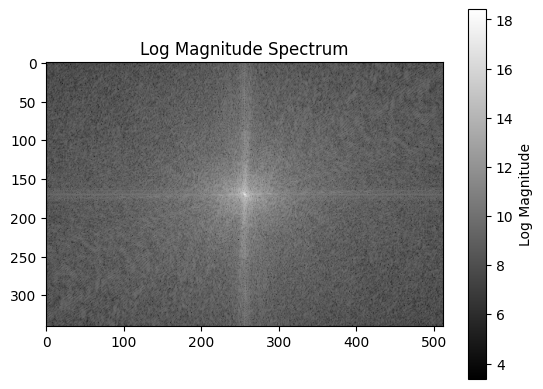

In [58]:
level_1_fft = get_pyramid_fft_slice(img)
plot_fft(level_1_fft)

In [96]:
def get_max_level(img):
    return int(np.log2(min(img.shape[0], img.shape[1])))-1

def create_pyramid(img):
    pyramid = []
    pyramid.append({'G' : img})
    for i in range(1, get_max_level(img)):
        fft = get_pyramid_fft_slice(img)
        img = get_image_from_fft(fft)
        expand_image_size = pyramid[i-1]['G'].shape
        pyramid.append({'G': img, 'Expanded_G': expand_image(img, expand_image_size)})
    for i in range(len(pyramid)-1):
        pyramid[i]['L'] = pyramid[i]['G'] - pyramid[i+1]['Expanded_G']
    return pyramid


#this method is use to expand an image size by 2 (both width and height)
#it uses zero padding (0, a1, 0, a2, 0, a3, ... , 0, an) to expand the image
# and then perform blur with gaussian filter with normalized kernel to 2 in order to fill the 0s
def expand_image(img, expanded_size):
    #create the expanded image
    expanded_img = np.zeros(expanded_size)
    # Iterate over the rows and columns of the smaller array (img) #TODO maybe improve
    for i in range(expanded_img.shape[0]):
        for j in range(expanded_img.shape[1]):
            # Only fill in values where it won't change the shape of expanded_img
            if i * 2 < expanded_img.shape[0] and j * 2 < expanded_img.shape[1] and i < img.shape[0] and j < img.shape[1]:
                expanded_img[i * 2, j * 2] = img[i, j]
    #create the gaussian kernel
    kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/16
    #perform the blur
    expanded_img = np.round(convolve2d(expanded_img, kernel))
    return expanded_img

#implement the convolution
def convolve2d(image, kernel):
    #get the kernel size
    kernel_size = kernel.shape[0]
    #get the image size
    image_height, image_width = image.shape
    #get the padding size
    padding_size = kernel_size//2
    #create the padded image
    padded_image = np.pad(image, padding_size, mode="constant")
    #create the result image
    result = np.zeros(image.shape)
    #perform the convolution
    for i in range(image_height):
        for j in range(image_width):
            result[i, j] = np.sum(padded_image[i:i+kernel_size, j:j+kernel_size]*kernel)
    return result





In [ ]:
pyramid = create_pyramid(img)

In [116]:

def plot_pyramid(pyramid):
    plt.subplots(1, len(pyramid), figsize=(20, 20))
    for i in range(len(pyramid)):
        plt.subplot(1, len(pyramid), i+1)
        plt.imshow(pyramid[i]['G'], cmap="gray")
        plt.title(f"Level {i}")
    plt.show()

def plot_pyramid_diff(pyramid):
    plt.subplots(1, len(pyramid)-1, figsize=(20, 20))
    for i in range(len(pyramid)-1):
        plt.subplot(1, len(pyramid)-1, i+1)
        plt.imshow(pyramid[i]['L'], cmap="gray")
        plt.title(f"Level {i} - Level {i+1}")

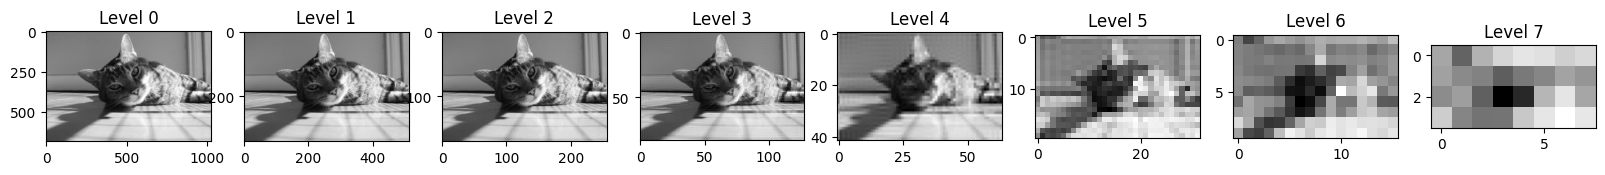

In [109]:
plot_pyramid(pyramid)

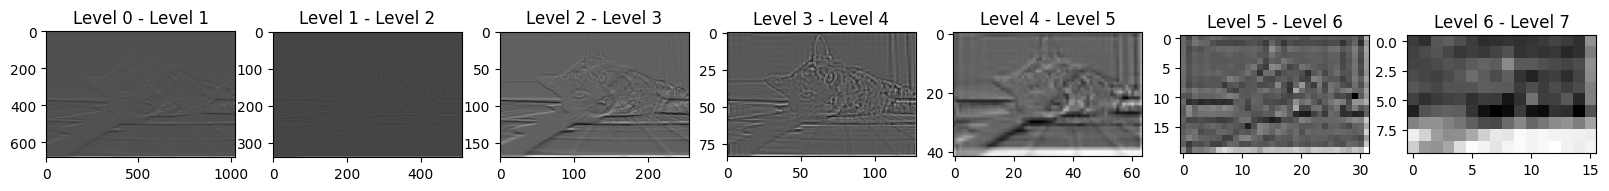

In [117]:
plot_pyramid_diff(pyramid)

In [121]:
apple_image = get_gray_img_mat('./assets/apple.jpeg')
apple_pyramid = create_pyramid(apple_image)
orange_image = get_gray_img_mat('./assets/orange.jpeg')
orange_pyramid = create_pyramid(orange_image)

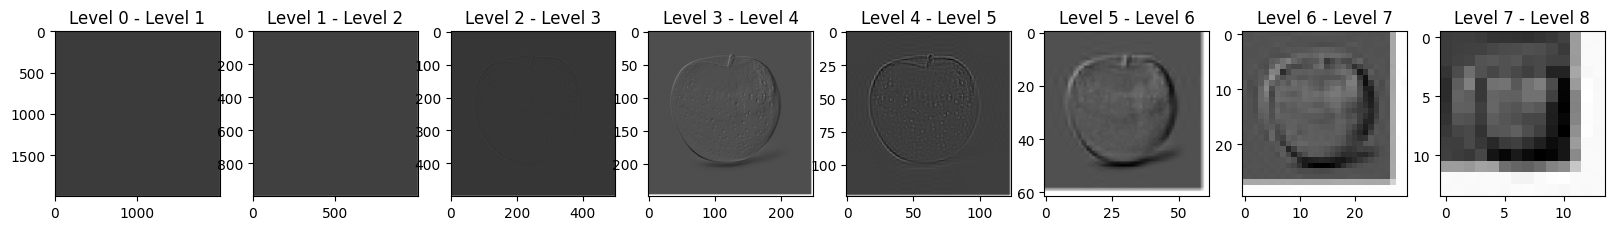

In [123]:
plot_pyramid_diff(apple_pyramid)

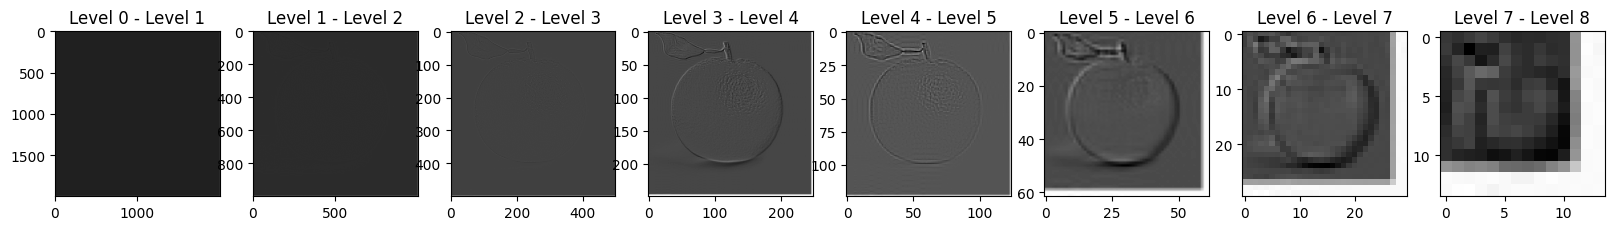

In [124]:
plot_pyramid_diff(orange_pyramid)

In [145]:



def create_mask_pyramid(img):
    pyramid = []
    pyramid.append({'G' : img//255})
    for i in range(1, get_max_level(img)):
        fft = get_pyramid_fft_slice(img)
        img = get_image_from_fft(fft)
        #noramlize value to be 0 or 1
        img = img//255
        pyramid.append({'G': img})
    return pyramid

mask = get_gray_img_mat('./assets/mask.jpeg')
mask_pyramid = create_mask_pyramid(mask)

In [148]:
mask_pyramid[0]['G'][1400:]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

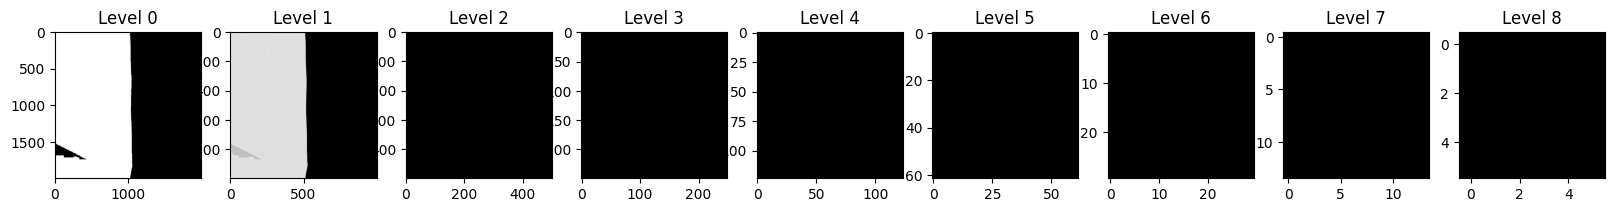

In [147]:
plot_pyramid(mask_pyramid)

In [137]:

def blend_images(apple_pyramid, orange_pyramid, mask_pyramid):
    blended_pyramid = []
    for i in range(len(apple_pyramid)-1):
        blended_pyramid.append({'G': apple_pyramid[i]['L']*mask_pyramid[i]['G'] + (1-mask_pyramid[i]['G'])*orange_pyramid[i]['L']})
    return blended_pyramid

In [139]:
blended_image = blend_images(apple_pyramid, orange_pyramid, mask_pyramid)

KeyboardInterrupt: 